In [1]:
!nvidia-smi

Tue Jan 12 10:52:06 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.27.04    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# **0. Import Libraies**

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import time

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# **1. Loading Data**

In [3]:
train_data = pd.read_csv('/content/drive/MyDrive/태양광발전량AI/train/train.csv')
subsam = pd.read_csv('/content/drive/MyDrive/태양광발전량AI/sample_submission.csv')

# **2. Pre-Processing Data**

In [4]:
DHI = []
DNI = []
WS = []
RH = []
T = []
TARGET = []

x = train_data.loc[:, ['DHI', 'DNI', 'WS', 'RH', 'T']] # input data(independent variables)
y = train_data.loc[:, ['TARGET']] # target data(dependent variable)

tensor_x = torch.tensor([]).to(device) # input data tensor
tensor_y = torch.tensor([]).to(device) # target data tensor
for i in range(len(train_data)//48-8):
  dfx = x.iloc[i*48:(i+7)*48,:] # each 7days input data
  DHI.append(dfx.DHI.mean())
  DNI.append(dfx.DNI.mean())
  WS.append(dfx.WS.mean())
  RH.append(dfx.RH.mean())
  T.append(dfx['T'].mean())
  dfx = (dfx-dfx.mean())/dfx.std() # normalization for each 7days input data
  temp_x = torch.tensor(dfx.to_numpy().reshape(-1, 5, 336), dtype=torch.float32).to(device)

  dfy = y.iloc[(i+7)*48:(i+9)*48] # each 2days target data
  TARGET.append(dfy.TARGET.mean())
  temp_y = torch.tensor(dfy.to_numpy().reshape(-1, 96), dtype=torch.float32).to(device)

  tensor_x = torch.cat([tensor_x, temp_x]) # concat
  tensor_y = torch.cat([tensor_y, temp_y]) # concat

# making mini-batch
batch_size = 32
train_batch = []
for i in range((len(train_data)//48-8)//batch_size+1):
  try: train_batch.append((tensor_x[i*batch_size:(i+1)*batch_size], tensor_y[i*batch_size:(i+1)*batch_size]))
  except: train_batch.append((tensor_x[i*batch_size:], tensor_y[i*batch_size:]))
train_batch = np.array(train_batch)

In [221]:
# 훈련에서 제외되는 2개의 batch 랜덤 선택
random = np.random.choice(np.arange(34), size=34, replace=False)
random

VALIDATION = train_batch[random[-2:]]
train_batch = train_batch[random[:-2]]

In [147]:
# fig = plt.figure(figsize=(15,10))
# fig.add_subplot(231)
# plt.scatter(DHI, TARGET, s=10)
# plt.title('DHI')
# fig.add_subplot(232)
# plt.scatter(DNI, TARGET, s=10)
# plt.title('DNI')
# fig.add_subplot(233)
# plt.scatter(WS, TARGET, s=10)
# plt.title('WS')
# fig.add_subplot(234)
# plt.scatter(RH, TARGET, s=10)
# plt.title('RH')
# fig.add_subplot(235)
# plt.scatter(T, TARGET, s=10)
# plt.title('T')
# plt.show()

# **3. Defining Loss**

In [205]:
def pinball_loss(pred, target, quantile):
  errors = target - pred
  return torch.mean(torch.max((quantile-1)*errors, quantile*errors))

quantiles = np.arange(0.1, 1, step=0.1)

# **4. Defining Model**

In [222]:
class SunLight(nn.Module):
  def __init__(self, cnn_out1, cnn_out2, cnn_out3, lstm_out, fc_out1, fc_out2, dilation1, dilation2):
    super(SunLight, self).__init__()
    self.cnn_out1 = cnn_out1
    self.cnn_out2 = cnn_out2
    self.cnn_out3 = cnn_out3
    self.lstm_out = lstm_out
    self.fc_out1 = fc_out1
    self.fc_out2 = fc_out2
    self.fc_out3 = fc_out3
    self.dilation1 = dilation1
    self.dilation2 = dilation2

    self.cnn1 = nn.Sequential(
        nn.Conv1d(in_channels=5, out_channels=cnn_out1, kernel_size=7, stride=1),
        nn.BatchNorm1d(cnn_out1),
        nn.ReLU(),
        nn.MaxPool1d(kernel_size=2, stride=2)
    )
    self.cnn2 = nn.Sequential(
        nn.Conv1d(in_channels=cnn_out1, out_channels=cnn_out2, kernel_size=7, stride=1, dilation=dilation1),
        nn.BatchNorm1d(cnn_out2),
        nn.ReLU(),
        nn.MaxPool1d(kernel_size=2, stride=2)
    )
    self.cnn3 = nn.Sequential(
        nn.Conv1d(in_channels=cnn_out2, out_channels=cnn_out3, kernel_size=7, stride=1, dilation=dilation2),
        nn.BatchNorm1d(cnn_out3),
        nn.ReLU(),
        nn.MaxPool1d(kernel_size=2, stride=2)
    )
    self.lstm = nn.LSTM(input_size=11, hidden_size=lstm_out, num_layers=1)
    self.gru = nn.GRU(input_size=11, hidden_size=lstm_out, num_layers=1)
    self.fc1 = nn.Sequential(
        nn.Linear(cnn_out3*11, fc_out1),
        # nn.Linear(lstm_out, fc_out1),
        nn.BatchNorm1d(fc_out1))
    self.fc2 = nn.Sequential(
        nn.Linear(fc_out1, fc_out2),
        nn.BatchNorm1d(fc_out2))
    self.fc3 = nn.Linear(fc_out2, 96)
    self.train_loss = []
    self.validation_loss = []

  def forward(self, x):
    x = self.cnn1(x)
    x = self.cnn2(x)
    x = self.cnn3(x)
    # x, (_, _) = self.lstm(x)
    # x, _ = self.gru(x)
    x = F.relu(self.fc1(x.reshape(x.size(0), -1)))
    # x = F.relu(self.fc1(x[:,-1,:]))
    x = F.relu(self.fc2(x))
    x = F.relu(self.fc3(x))

    return x

In [11]:
# # checking tensor size after CNN layers
# for i, (x,y) in enumerate(train_batch):
#   if i == 1: break
# temp_model = SunLight(64, 128, 256, 64, 256, 128, 64, 4, 8).to(device)
# x = temp_model.cnn1(x)
# x = temp_model.cnn2(x)
# x = temp_model.cnn3(x)
# x, (_, _) = temp_model.lstm(x)
# # x = temp_model.fc1(x.reshape(x.size(0),-1))
# x = F.relu(temp_model.fc1(x[:,-1,:]))
# x.size()

# **5. Setting Hyper Parameters & Making 9 Models**

In [223]:
cnn_out1 = 32
cnn_out2 = 64
cnn_out3 = 128
lstm_out = 64
fc_out1 = 512
fc_out2 = 128

dilation1 = 4
dilation2 = 8

learning_rate = [None, 0.01, 0.1, 0.05, 0.05, 0.05, 0.05, 0.05, 0.1, 0.01]
# learning_rate = [None, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001]
# epochs = [None, 20, 25, 30, 35, 40, 35, 30, 25, 20]
epochs = 20
print_cycle = 5

split = 5 # the number of k for cross validation
ran = len(train_batch)//split*split # the number of random indices

models = [None]+[SunLight(cnn_out1, cnn_out2, cnn_out3, 
                          lstm_out, fc_out1, fc_out2, dilation1, dilation2).to(device) for i in range(9)] # 9 models

# **6. Training Models**

## **6-1. Training Models (K-Fold Cross Validation)**

In [224]:
def model_train(model, quantile, data_set, optimizer, is_train=True):
  running_loss = 0
  for i, (x, y) in enumerate(data_set):
    if is_train:
      out = model(x)

      loss = pinball_loss(out, y, quantile)
      running_loss += loss.item()

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
    else:
      with torch.no_grad():
        out = model(x)

        loss = pinball_loss(out, y, quantile)
        running_loss += loss.item()

  return running_loss, optimizer

In [226]:
# k-fold Cross Validation Training
# for quantile in quantiles:
for quantile in (0.5, 0.4, 0.6, 0.3, 0.7, 0.2, 0.8, 0.1, 0.9):
  m = int(quantile*10) # models' index number
  model = models[m] # choosing model
  optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate[m]) # defining optimizer

  for epoch in range(epochs):
    if print_cycle==1:
      t1 = time.time()
    elif (epoch+1)%print_cycle==1:
      t1 = time.time()

    # generating random indices for k-fold cross validation
    v = np.random.choice(np.arange(len(train_batch)), size=len(train_batch), replace=False)
    v_remain = v[ran:]
    v = v[:ran].reshape(split, -1)
    
    # CV train & validation loss list
    k_train_loss = []
    k_validation_loss = []
    
    for k in range(split):
      # defining train & validation sets
      train_set = train_batch[np.concatenate([v[(k+i)%split] for i in range(split-1)] + [v_remain])]
      validation_set = train_batch[v[(k+split-1)%split]]

      # train part
      running_loss, optimizer = model_train(model, quantile, train_set, optimizer)
      k_train_loss.append(running_loss/len(train_set))

      # validation part
      running_loss, _ = model_train(model, quantile, validation_set, optimizer, is_train=False)
      k_validation_loss.append(running_loss/len(validation_set))
    
    if (epoch+1)%print_cycle==0:
      t2 = time.time()
      print(f'Model{m}, Epoch: [{epoch+1}/{epochs}], Training Mean Loss: {sum(k_train_loss)/len(k_train_loss):.4f}', end=' ')
      print(f'Validation Mean Loss: {sum(k_validation_loss)/len(k_validation_loss):.4f}, Running Time: {t2-t1:.2f} seconds')
    model.train_loss.append(sum(k_train_loss)/len(k_train_loss))
    model.validation_loss.append(sum(k_validation_loss)/len(k_validation_loss))
  models[m] = model
  print()

Model5, Epoch: [5/20], Training Mean Loss: 3.4111 Validation Mean Loss: 3.3130, Running Time: 4.02 seconds
Model5, Epoch: [10/20], Training Mean Loss: 2.6775 Validation Mean Loss: 2.6643, Running Time: 3.94 seconds
Model5, Epoch: [15/20], Training Mean Loss: 2.3553 Validation Mean Loss: 2.2724, Running Time: 3.94 seconds
Model5, Epoch: [20/20], Training Mean Loss: 2.0569 Validation Mean Loss: 2.0762, Running Time: 4.08 seconds

Model4, Epoch: [5/20], Training Mean Loss: 3.1600 Validation Mean Loss: 3.0074, Running Time: 4.07 seconds
Model4, Epoch: [10/20], Training Mean Loss: 2.5036 Validation Mean Loss: 2.3857, Running Time: 3.97 seconds
Model4, Epoch: [15/20], Training Mean Loss: 2.1796 Validation Mean Loss: 2.2050, Running Time: 3.96 seconds
Model4, Epoch: [20/20], Training Mean Loss: 2.1570 Validation Mean Loss: 2.2555, Running Time: 4.04 seconds

Model6, Epoch: [5/20], Training Mean Loss: 3.2133 Validation Mean Loss: 3.0492, Running Time: 4.01 seconds
Model6, Epoch: [10/20], Train

In [227]:
for m in range(1, 10):
  running_loss, _ = model_train(models[m], quantile, VALIDATION, optimizer, is_train=False)
  print(running_loss/2)

4.912194609642029
5.450512409210205
4.4107664823532104
4.368738532066345
2.3674659729003906
2.1303069293498993
1.6207095384597778
1.2682103514671326
1.417794108390808


## **6-2. Training Models (Non-Validation)**

In [174]:
# Non Validation Training
# for quantile in quantiles:
#   m = int(quantile*10)
#   model = models[m]
#   optimizer = torch.optim.Adagrad(model.parameters(), lr=learning_rate)

#   for epoch in range(epochs):
#     if (epoch+1)%10==1:
#       t1 = time.time()
#     running_loss = 0

#     for i, (x, y) in enumerate(train_batch):
#       out = model(x)

#       loss = pinball_loss(out, y, quantile)
#       running_loss += loss
      
#       optimizer.zero_grad()
#       loss.backward()
#       optimizer.step()

#       if i+1 == len(train_batch) and (epoch+1)%10==0:
#         t2 = time.time()
#         print(f'Model{m}, Epoch: [{epoch+1}/{epochs}], Mean Loss: {running_loss/len(train_batch):.4f}, Running Time: {t2-t1:.2f} seconds')
#     model.train_loss.append(running_loss/len(train_batch))

#   models[m] = model
#   print()

Model1, Epoch: [10/20], Mean Loss: 1.4358, Running Time: 1.87 seconds
Model1, Epoch: [20/20], Mean Loss: 1.2545, Running Time: 1.88 seconds

Model2, Epoch: [10/20], Mean Loss: 2.5324, Running Time: 1.79 seconds
Model2, Epoch: [20/20], Mean Loss: 2.3665, Running Time: 1.82 seconds

Model3, Epoch: [10/20], Mean Loss: 3.2206, Running Time: 1.87 seconds
Model3, Epoch: [20/20], Mean Loss: 2.7940, Running Time: 1.89 seconds

Model4, Epoch: [10/20], Mean Loss: 3.7971, Running Time: 1.90 seconds
Model4, Epoch: [20/20], Mean Loss: 3.2484, Running Time: 1.79 seconds

Model5, Epoch: [10/20], Mean Loss: 4.0713, Running Time: 1.82 seconds
Model5, Epoch: [20/20], Mean Loss: 3.2694, Running Time: 1.82 seconds

Model6, Epoch: [10/20], Mean Loss: 3.5532, Running Time: 1.84 seconds
Model6, Epoch: [20/20], Mean Loss: 3.4531, Running Time: 1.80 seconds

Model7, Epoch: [10/20], Mean Loss: 3.6019, Running Time: 1.82 seconds
Model7, Epoch: [20/20], Mean Loss: 2.7663, Running Time: 1.86 seconds



KeyboardInterrupt: ignored

# **7. Comparing Train & Validation Loss**

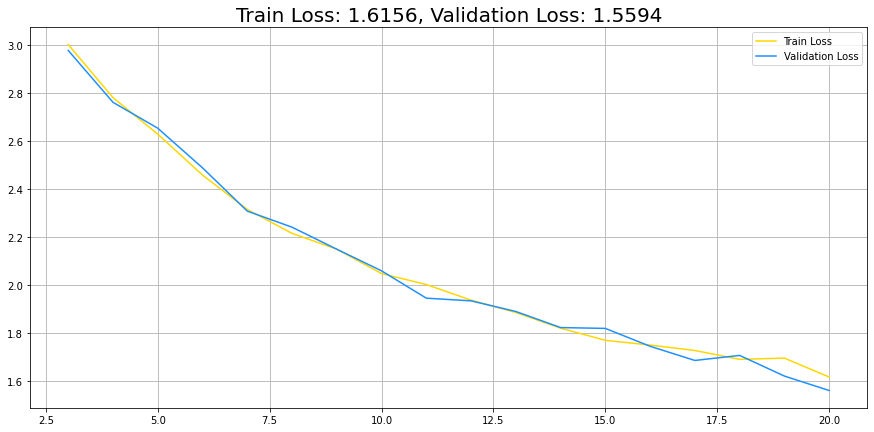

In [141]:
mean_t_loss = []
mean_v_loss = []
for e in range(epochs):
  t_loss_sum = 0
  v_loss_sum = 0
  for m in range(1, 10):
    t_loss_sum += models[m].train_loss[e]
    v_loss_sum += models[m].validation_loss[e]
  mean_t_loss.append(t_loss_sum/9)
  mean_v_loss.append(v_loss_sum/9)

plt.figure(figsize=(15,7))
plt.plot(np.arange(3,epochs+1), mean_t_loss[2:], color='gold', label='Train Loss')
plt.plot(np.arange(3,epochs+1), mean_v_loss[2:], color='dodgerblue', label='Validation Loss')
plt.legend()
plt.title(f'Train Loss: {mean_t_loss[-1]:.4f}, Validation Loss: {mean_v_loss[-1]:.4f}', fontsize=20)
plt.grid()
plt.show()

# **8. Plotting Validation Loss of 9 Models**

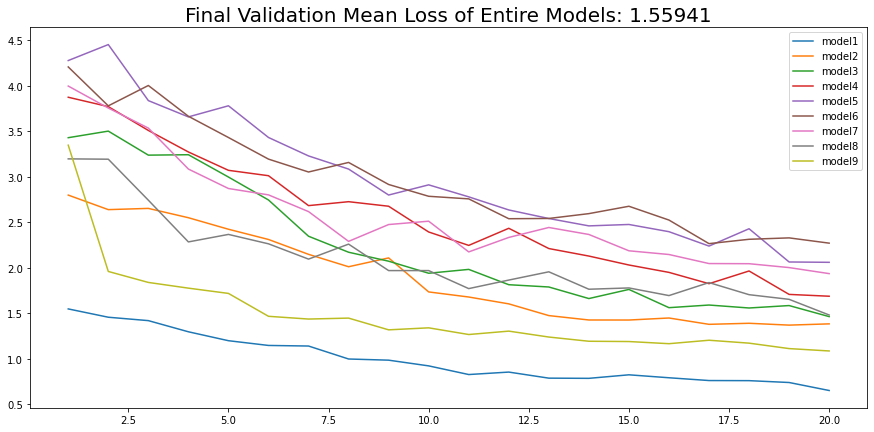

In [142]:
loss_sum = 0
plt.figure(figsize=(15,7))
for m in range(1, 10):
  loss_sum += models[m].validation_loss[-1]
  plt.plot(np.arange(1, epochs+1), models[m].validation_loss, label=f'model{m}')
plt.legend()
plt.title(f'Final Validation Mean Loss of Entire Models: {loss_sum/9:.5f}', fontsize=20)
plt.show()

# **9. Making Test Submission File**

In [143]:
def make_test_tensor(test_tensor, num):
  test_data = pd.read_csv(f'/content/drive/MyDrive/태양광발전량AI/test/{num}.csv')
  test = test_data.iloc[:, 3:8]
  test = (test-test.mean())/test.std()
  test_temp = torch.tensor(test.to_numpy(), dtype=torch.float32).reshape(1, 5, 336).to(device)
  test_tensor = torch.cat([test_tensor, test_temp]).to(device)

  return test_tensor

test_tensor = torch.tensor([]).to(device)
for t in range(81):
  test_tensor = make_test_tensor(test_tensor, t)
for m in range(1,10):
  with torch.no_grad():  
    my_pred = models[m](test_tensor).to('cpu')  
    for t in range(81):
      subsam.loc[t*96:(t+1)*96-1, f'q_{m*0.1:.1f}'] = my_pred[t].numpy()

In [144]:
trial = '016-2'
subsam.to_csv(f'/content/drive/MyDrive/태양광발전량AI/submission/submission{trial}.csv', index=False)

# **10. Save Models**

In [145]:
for m in range(1, 10):
  torch.save(models[m].state_dict(), f'/content/drive/MyDrive/태양광발전량AI/models/{trial}_model{m}.pth')

In [146]:
# cnn_out1 = 64
# cnn_out2 = 128
# cnn_out3 = 256
# lstm_out = 64
# fc_out1 = 1024
# fc_out2 = 128
# fc_out3 = 64

# dilation1 = 4
# dilation2 = 8

models = [None]

for m in range(1, 10):
  model = SunLight(cnn_out1, cnn_out2, cnn_out3, lstm_out, fc_out1, fc_out2, fc_out3, dilation1, dilation2).to(device)
  model.load_state_dict(torch.load(f'/content/drive/MyDrive/태양광발전량AI/models/{trial}_model{m}.pth'))
  models.append(model)